


this code uses some progarms direactly from the os that might need to be installed on the operators machine 

---

so far we have used 
dcm2niix to convert dcm to nii files we do this for proformance reasons as the data is lare and saving time is nacceary 

and FSL for the preprocessing 


In [1]:
# IMPORTS 
import subprocess
import os
import nibabel as nib
from nipype.interfaces.fsl import MCFLIRT
from nipype import Workflow, Node, MapNode, config



# TODO questions 

- what is that thing with the relative path does it contain any important info ? 
- do all file pipelines need sort ? 
- is the atlas mapping a bottle neck ? if so multi process it 


In [2]:
# some hose keeping base 
# configure Nipype for multiprocessing
# Continue even if one task fails
config.set("execution", "stop_on_first_crash", "false")  
# Keep all outputs
config.set("execution", "remove_unnecessary_outputs", "false")  



In [25]:
# defining some helper function we will use later 
#CONSTANTS
PLUGIN = "MultiProc"
PLUGIN_ARGS = {"n_procs": 4}
# returns a list of files with a absolute path from a base dir ending with given suffix  
def get_files_list(base_dir, *suffixes):

    files_list = []
    abs_base_path = os.path.abspath(base_dir)
    for curr_path, dirs, files in os.walk(abs_base_path):
        
        for file in files:
            if any(file.lower().endswith(suffix) for suffix in suffixes):
                files_list.append(os.path.join(curr_path, file))
    
    return files_list
            
    
def create_output_paths(input_files, base_dir,suffix):
    output_paths = []
    
    for i, input_file in enumerate(input_files):
        subject_dir = os.path.join(base_dir, str(i+1) )
        os.makedirs(subject_dir, exist_ok=True)
        output_paths.append(os.path.join(subject_dir,os.path.basename(input_file)) + suffix )
    
    return output_paths
    
def create_workflow(name,nodes):
    work_flow = Workflow(name=name)
    work_flow.base_dir = os.path.abspath("./workflows/")
    work_flow.add_nodes(nodes)
    return work_flow
    
print("done")

done


# A look at the data ? some explanation ? 

## preprocessing


In [82]:
#  converting all dicom files in RAW data to nii files 
# TODO find a way to stop printing so much stuff  
# TODO can this and should this be done with nipype

def convert_all_dicoms(base_dir, output_base_dir):
    
    index = 0
    
    for curr_path, dirs, files in os.walk(base_dir):
        
        # Check if we are in the deepest folder containing DICOM files
        if any(file.lower().endswith('.dcm') for file in files):
            
            index += 1
            output_dir = os.path.join(output_base_dir, str(index))
            os.makedirs(output_dir, exist_ok=True)
            
            # Convert using dcm2niix
            command = ['dcm2niix', '-o', output_dir, curr_path]
            subprocess.run(command, check=True)


nii_base_dir = os.path.abspath("./DATA/nii/")
os.makedirs(nii_base_dir, exist_ok=True)
convert_all_dicoms("./DATA/RAW/", nii_base_dir)
print("\n\nConverted all dicom to nii files\n\n")

Chris Rorden's dcm2niiX version v1.0.20220720  (JP2:OpenJPEG) GCC13.2.0 x86-64 (64-bit Linux)
Found 6720 DICOM file(s)
Philips Scaling Values RS:RI:SS = 1.41123:0:0.000906086 (see PMC3998685)
Convert 6720 DICOM as /home/adi/Desktop/keep/code/git/reops/ANDI/ANDI-/DATA/nii/1/I251176_Resting_State_fMRI_20110816150745_501 (64x64x48x140)
Conversion required 5.684437 seconds (4.353227 for core code).
Chris Rorden's dcm2niiX version v1.0.20220720  (JP2:OpenJPEG) GCC13.2.0 x86-64 (64-bit Linux)
Found 6720 DICOM file(s)
Philips Scaling Values RS:RI:SS = 1.22222:0:0.000551844 (see PMC3998685)
Convert 6720 DICOM as /home/adi/Desktop/keep/code/git/reops/ANDI/ANDI-/DATA/nii/2/I417987_Resting_State_fMRI_20140227155425_501 (64x64x48x140)
Conversion required 5.697188 seconds (4.556119 for core code).
Chris Rorden's dcm2niiX version v1.0.20220720  (JP2:OpenJPEG) GCC13.2.0 x86-64 (64-bit Linux)
Found 6720 DICOM file(s)
Philips Scaling Values RS:RI:SS = 1.63077:0:0.000732953 (see PMC3998685)
Convert 6720

In [22]:
# mapped realign 

# make sure that a path for the realignment output exists
realigned_base_dir = os.path.abspath("./DATA/realigned/")
os.makedirs(realigned_base_dir, exist_ok=True)
# get a list of input files and output files with abs path
nii_files = get_files_list(nii_base_dir,"nii")
realigned_paths = create_output_paths(nii_files, realigned_base_dir, ".gz")

# use MapNode to process multiple files
realign_mapnode = MapNode(
    MCFLIRT(cost="normcorr", save_mats=True, save_plots=True),
    iterfield=["in_file", "out_file"],
    name="realign_mapnode"
)

# assign input and output files
realign_mapnode.inputs.in_file = nii_files
realign_mapnode.inputs.out_file = realigned_paths

wf_realign = create_workflow("realignment_workflow", [realign_mapnode])
wf_realign.run(plugin=PLUGIN, plugin_args=PLUGIN_ARGS)

print("\n\n realignment completed for all files!")


241116-12:43:01,469 nipype.workflow INFO:
	 Workflow realignment_workflow settings: ['check', 'execution', 'logging', 'monitoring']
241116-12:43:01,473 nipype.workflow INFO:
	 Running in parallel.
241116-12:43:01,476 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.67/13.67, Free processors: 4/4.
241116-12:43:03,476 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 6 jobs ready. Free memory (GB): 13.67/13.67, Free processors: 4/4.
241116-12:43:03,604 nipype.workflow INFO:
	 [Job 1] Cached (_realign_mapnode0).
241116-12:43:03,606 nipype.workflow INFO:
	 [Job 2] Cached (_realign_mapnode1).
241116-12:43:03,610 nipype.workflow INFO:
	 [Job 3] Cached (_realign_mapnode2).
241116-12:43:03,612 nipype.workflow INFO:
	 [Job 4] Cached (_realign_mapnode3).
241116-12:43:05,481 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 13.67/13.67, Free processors: 4/4.
241116-12:43:05,656 nipype.workflow INFO:
	 [Job 5]

In [66]:
# normalization
from nipype.interfaces.fsl import FLIRT, FNIRT, Info

normalized_base_dir = os.path.abspath("./DATA/normalized/")
os.makedirs(normalized_base_dir, exist_ok=True)

# create input and output paths list 
# realigned_files = get_files_list("./DATA/realigned/", "nii", "nii.gz")
realigned_files = get_files_list(realigned_base_dir, "nii", "nii.gz")
normalized_paths = create_output_paths(realigned_files,normalized_base_dir, "")

# Define MNI template ( template to normalize the functional data to )
standard_template = Info.standard_image("MNI152_T1_2mm_brain.nii.gz")

# FLIRT node for linear alignment
flirt_mapnode = MapNode(
    FLIRT(reference=standard_template, out_matrix_file="affine.mat"),
    iterfield=["in_file", "out_file"],
    name="flirt_mapnode"
)

flirt_mapnode.inputs.in_file = realigned_files
flirt_mapnode.inputs.out_file = normalized_paths

# Workflow
wf_normalize = create_workflow("normalization_workflow",[flirt_mapnode])
# Run the workflow
wf_normalize.run(plugin=PLUGIN, plugin_args=PLUGIN_ARGS)

print("\n\nNormalization completed!\n\n")


241117-20:03:15,725 nipype.workflow INFO:
	 Workflow normalization_workflow settings: ['check', 'execution', 'logging', 'monitoring']
241117-20:03:15,730 nipype.workflow INFO:
	 Running in parallel.
241117-20:03:15,733 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.67/13.67, Free processors: 4/4.
241117-20:03:17,738 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 6 jobs ready. Free memory (GB): 13.67/13.67, Free processors: 4/4.
241117-20:03:18,92 nipype.workflow INFO:
	 [Node] Setting-up "_flirt_mapnode0" in "/home/adi/Desktop/keep/code/git/reops/ANDI/ANDI-/workflows/normalization_workflow/flirt_mapnode/mapflow/_flirt_mapnode0".
241117-20:03:18,94 nipype.workflow INFO:
	 [Node] Setting-up "_flirt_mapnode1" in "/home/adi/Desktop/keep/code/git/reops/ANDI/ANDI-/workflows/normalization_workflow/flirt_mapnode/mapflow/_flirt_mapnode1".
241117-20:03:18,97 nipype.workflow INFO:
	 [Node] Setting-up "_flirt_mapnode2" in "/home/adi/Desktop/ke

In [69]:
import nibabel as nib

# a look at the atlas to see if its diemsiions match our normalized data 
# Load images
atlas_img_path = "./atlas/MNI-maxprob-thr25-2mm.nii.gz"
atlas_img = nib.load(atlas_img_path)
normalized_img_path = os.path.abspath("./DATA/normalized/1/I238623_Resting_State_fMRI_20110602075636_501.nii.gz")
normalized_img = nib.load(normalized_img_path)

# Compare affine matrices
print("Atlas affine:\n", atlas_img.affine)
print("Normalized brain affine:\n", normalized_img.affine)

# Compare voxel dimensions
print("Atlas voxel size:", atlas_img.header.get_zooms())
print("Normalized brain voxel size:", normalized_img.header.get_zooms())

Atlas affine:
 [[  -2.    0.    0.   90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]
Normalized brain affine:
 [[  -2.    0.    0.   90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]
Atlas voxel size: (2.0, 2.0, 2.0)
Normalized brain voxel size: (2.0, 2.0, 2.0)


In [70]:
# before mapping to the atlas we need to create transformation matrix  
# from MNI space to the atlas space 

flirt = FLIRT()
flirt.inputs.in_file = normalized_img_path  
flirt.inputs.reference = atlas_img_path  
flirt.inputs.out_matrix_file = "mni_to_atlas_flirt.mat"  
flirt.inputs.out_file = "./atlas/mni_to_atlas_flirt_output.nii.gz" 
flirt.run()

print("done")

done


In [77]:
# map to an atlas to extract ROIs for feature extraction 
from nipype.interfaces.fsl import FLIRT, ApplyXFM, ExtractROI, Info, Merge
from nipype.interfaces.utility import IdentityInterface

# Define paths
# atlas_image = Info.standard_image("HarvardOxford-cortical-1mm.nii.gz")  
atlas_base_dir = os.path.abspath("./DATA/atlas/")
os.makedirs(atlas_base_dir , exist_ok=True)

normalized_files = get_files_list(normalized_base_dir,"nii","nii.gz")
normalized_files.sort()
atlas_paths = create_output_paths(normalized_files,atlas_base_dir, "")
atlas_paths.sort()
transformation_matrix = "mni_to_atlas_flirt.mat"  

# go over each file and map it individualy as I cant get this to work in a nipypeline 
# in time 
for normalized_file, atlas_path in zip(normalized_files, atlas_paths):
    applyxfm_mapnode = ApplyXFM()  
    applyxfm_mapnode.inputs.in_file = normalized_file  
    applyxfm_mapnode.inputs.reference = atlas_img_path 
    applyxfm_mapnode.inputs.in_matrix_file = transformation_matrix  
    applyxfm_mapnode.inputs.out_file = atlas_path  
    applyxfm_mapnode.run()
    print(f" norm |{normalized_file}| atlas |{atlas_path}|")

print("Mapped all files to atlas")

 norm |/home/adi/Desktop/keep/code/git/reops/ANDI/ANDI-/DATA/normalized/1/I238623_Resting_State_fMRI_20110602075636_501.nii.gz| atlas |/home/adi/Desktop/keep/code/git/reops/ANDI/ANDI-/DATA/atlas/1/I238623_Resting_State_fMRI_20110602075636_501.nii.gz|
 norm |/home/adi/Desktop/keep/code/git/reops/ANDI/ANDI-/DATA/normalized/2/I417936_Extended_Resting_State_fMRI_20140314062732_501.nii.gz| atlas |/home/adi/Desktop/keep/code/git/reops/ANDI/ANDI-/DATA/atlas/2/I417936_Extended_Resting_State_fMRI_20140314062732_501.nii.gz|
 norm |/home/adi/Desktop/keep/code/git/reops/ANDI/ANDI-/DATA/normalized/3/I417987_Resting_State_fMRI_20140227155425_501.nii.gz| atlas |/home/adi/Desktop/keep/code/git/reops/ANDI/ANDI-/DATA/atlas/3/I417987_Resting_State_fMRI_20140227155425_501.nii.gz|
 norm |/home/adi/Desktop/keep/code/git/reops/ANDI/ANDI-/DATA/normalized/4/I223896_Resting_State_fMRI_20110314160431_501.nii.gz| atlas |/home/adi/Desktop/keep/code/git/reops/ANDI/ANDI-/DATA/atlas/4/I223896_Resting_State_fMRI_20110

In [79]:
from nipype.interfaces.fsl.utils import ImageMeants


mean_base_dir = os.path.abspath("./DATA/mean/")
os.makedirs(mean_base_dir, exist_ok=True)

# create input and output paths list 
atlas_files = get_files_list(realigned_base_dir, "nii", "nii.gz")
mean_paths = create_output_paths(atlas_files, mean_base_dir, "")

# FLIRT node for linear alignment
meants_mapnode = MapNode(
    ImageMeants(),
    iterfield=["in_file", "out_file"],
    name="meants_mapnode"
)

meants_mapnode.inputs.in_file = atlas_files
meants_mapnode.inputs.out_file = mean_paths

# Workflow
wf_meants = create_workflow("mean_workflow",[meants_mapnode])
wf_meants.run(plugin=PLUGIN, plugin_args=PLUGIN_ARGS)

print("\n\nMean feature extraction completed!\n\n")

241117-20:29:13,111 nipype.workflow INFO:
	 Workflow mean_workflow settings: ['check', 'execution', 'logging', 'monitoring']
241117-20:29:13,117 nipype.workflow INFO:
	 Running in parallel.
241117-20:29:13,120 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.67/13.67, Free processors: 4/4.
241117-20:29:15,123 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 6 jobs ready. Free memory (GB): 13.67/13.67, Free processors: 4/4.
241117-20:29:15,458 nipype.workflow INFO:
	 [Node] Setting-up "_meants_mapnode0" in "/home/adi/Desktop/keep/code/git/reops/ANDI/ANDI-/workflows/mean_workflow/meants_mapnode/mapflow/_meants_mapnode0".
241117-20:29:15,460 nipype.workflow INFO:
	 [Node] Setting-up "_meants_mapnode1" in "/home/adi/Desktop/keep/code/git/reops/ANDI/ANDI-/workflows/mean_workflow/meants_mapnode/mapflow/_meants_mapnode1".
241117-20:29:15,462 nipype.workflow INFO:
	 [Node] Setting-up "_meants_mapnode2" in "/home/adi/Desktop/keep/code/git/reops

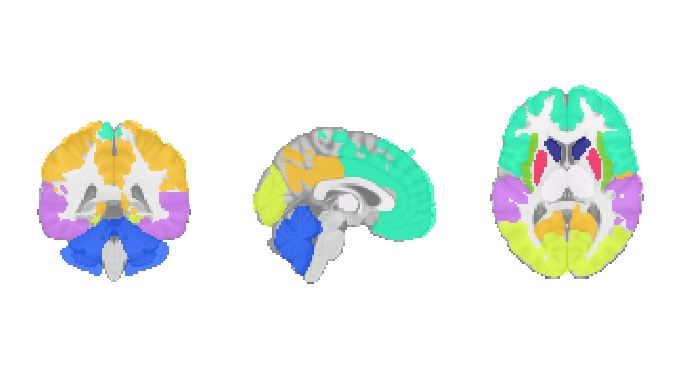

In [86]:
from nilearn import plotting
import nibabel as nib

# Visualize parcellation atlas
plotting.plot_roi(atlas_img_path, draw_cross=False, annotate=False);

'/home/adi/Downloads/y/data/standard/MNI152_T1_3mm_brain.nii.gz'

'/home/adi/Downloads/y/data/standard/HarvardOxford-cortical-3mm.nii.gz'

In [ ]:
nii_files = get_files_list("./DATA/realigned/","nii","nii.gz")
print(nii_files)

In [81]:
import os
import nibabel as nib

def check_t1_image_in_directory(dataset_path):
    """
    Check if a T1-weighted image is available in the specified dataset directory.

    Parameters:
    - dataset_path: Path to the dataset directory (including RAW and nii subdirectories).

    Returns:
    - t1_image: The T1-weighted image if found, else None.
    - t1_filepath: The file path of the found T1-weighted image, if any.
    """
    # Define possible T1-weighted image patterns in filenames
    t1_patterns = ['T1w', 'MPRAGE', 'SPGR']

    # Traverse directories to find potential T1-weighted images
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            # Check if the file matches any of the patterns
            if any(pattern in file for pattern in t1_patterns):
                try:
                    t1_filepath = os.path.join(root, file)
                    t1_img = nib.load(t1_filepath)  # Load the T1-weighted image
                    print(f"Found T1-weighted image: {file}")
                    return t1_img, t1_filepath
                except Exception as e:
                    print(f"Error loading T1-weighted image: {file}. Error: {e}")
                    continue

    print("No T1-weighted image found.")
    return None, None

def check_fmri_image_in_directory(dataset_path):
    """
    Check if an fMRI image is available in the specified dataset directory.

    Parameters:
    - dataset_path: Path to the dataset directory (including RAW and nii subdirectories).

    Returns:
    - fmri_img: The fMRI image if found, else None.
    - fmri_filepath: The file path of the found fMRI image, if any.
    """
    # Traverse directories to find fMRI images (assumes these are in .nii.gz format)
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.nii') or file.endswith('.nii.gz'):
                try:
                    fmri_filepath = os.path.join(root, file)
                    fmri_img = nib.load(fmri_filepath)
                    print(f"Found fMRI image: {file}")
                    return fmri_img, fmri_filepath
                except Exception as e:
                    print(f"Error loading fMRI image: {file}. Error: {e}")
                    continue

    print("No fMRI image found.")
    return None, None

# Example usage:
dataset_path_raw = './DATA/RAW'  # Path to your dataset's RAW directory
dataset_path_nii = './DATA/nii'  # Path to your dataset's nii directory

# Check for T1-weighted image in RAW and nii directories
t1_img, t1_filepath = check_t1_image_in_directory(dataset_path_raw)
if not t1_img:
    t1_img, t1_filepath = check_t1_image_in_directory(dataset_path_nii)

# Check for fMRI image in RAW and nii directories
fmri_img, fmri_filepath = check_fmri_image_in_directory(dataset_path_raw)
if not fmri_img:
    fmri_img, fmri_filepath = check_fmri_image_in_directory(dataset_path_nii)

if t1_img:
    print(f"T1-weighted image found at: {t1_filepath}")
else:
    print("No T1-weighted image found for coregistration.")

if fmri_img:
    print(f"fMRI image found at: {fmri_filepath}")
else:
    print("No fMRI image found.")


No T1-weighted image found.
No T1-weighted image found.
No fMRI image found.
Found fMRI image: I423209_Extended_Resting_State_fMRI_20140501070825_501.nii
No T1-weighted image found for coregistration.
fMRI image found at: ./DATA/nii/5/I423209_Extended_Resting_State_fMRI_20140501070825_501.nii
